# 基本的な操作の確認と予測

操作の確認と、各種ベースラインとなる予測手法を動かしてみる。手を動かすことを目的とする。

##　結果
- 芳香環の有無や個数が最大吸収波長に高い相関を持つ　→ ベンゼン環の構造を学習させる方法が有用である可能性
- モルガンフィンガープリントに、次元削減はあまり役に立たなそうである
- ニューラルネットワークの学習を過学習などを起こさずに行うのが先決そう

In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
import  sklearn
sklearn.__version__

'1.0.2'

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

[16:52:29] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [16:52:29] Enabling RDKit 2019.09.3 jupyter extensions


In [4]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [5]:
dataset_df = pd.read_csv("../datasets/dataset.csv")
for col in dataset_df.columns:
    if col == "SMILES":
        continue
    dataset_df[col] = dataset_df[col].fillna(0)
dataset_df.head()

,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print("データ数: {}".format(len(dataset_df)))

データ数: 198655


In [7]:
def get_morgan_fingerprint(smile, radius=2, bits=1024):
    mol_ = Chem.MolFromSmiles(smile)
    bit_morgan_ = {}
    if mol_ == None:
        return [0] * bits
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol_, radius=radius, nBits=bits, bitInfo=bit_morgan_)
    return np.array(fp)

In [8]:
%%time
# 5min
dataset_df["morgan_fingerprint"] = dataset_df["SMILES"].map(get_morgan_fingerprint)
dataset_df.head()

CPU times: user 2min 15s, sys: 736 ms, total: 2min 16s
Wall time: 2min 17s


,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,morgan_fingerprint
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
import torch
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetRegressor
from skorch.callbacks import Callback, Checkpoint, EarlyStopping
from skorch.dataset import CVSplit

In [22]:
class Net(nn.Module):
    def __init__(self, input=1232):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input, 128)
        self.layer2 = nn.Linear(128, 128, bias=True)
        self.layer3 = nn.Linear(128, 1, bias=True)
 
    def forward(self, x):
        x = x.float()
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return x

In [11]:
# データセットの定義と分割
X = np.array(dataset_df["morgan_fingerprint"].values.tolist())
X_rest = dataset_df.drop(['SMILES','λmax',"morgan_fingerprint"], axis=1).values
X = np.hstack([X, X_rest])
y = dataset_df["λmax"].values
y = y.reshape([-1,1])

In [12]:
X = X.astype(np.float32)
y = y.astype(np.float32)


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [82]:
y_train_mean, y_train_std = np.mean(y_train), np.std(y_train)
y_train_max = np.max(y_train)
# y_train = y_train / y_train_mean

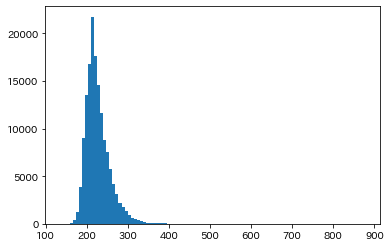

In [83]:
plt.hist(y_train,bins=100)
plt.show()

In [92]:
%%time
# 10min


monitor = lambda Net: all(Net.history[-1, ('train_loss_best', 'valid_loss_best')])

# set param(make trainer)
model = NeuralNetRegressor(
                    Net,
                    max_epochs=100,
                    lr=0.001,
                    warm_start=True,
                    optimizer=torch.optim.Adam,
                    # optimizer=torch.optim.SGD,
                    # optimizer__momentum=0.9,
                    optimizer__weight_decay=0.001,
                    iterator_train__shuffle=True,
                    callbacks=[Checkpoint(), EarlyStopping()],
                    # train_split=CVSplit(cv=10, stratified=True, random_state=0)
                    device="cuda",
                    
                )

# learn
model.fit(X_train, y_train)

# predict
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
# print(y_test-y_pred) # 真値と予測値の差分
 
# print precision, recall, f1-score, support
# print(classification_report(y_test, y_pred))
# print("score:", accuracy_score(y_test, y_pred))

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1     1255.4646      482.7145     +  4.5254
      2      445.0025      419.3628     +  4.4167
      3      415.0681      441.4755        4.6426
      4      402.5466      403.2054     +  4.6161
      5      396.3514      380.1195     +  4.4980
      6      378.6754      399.0137        4.4928
      7      376.0438      371.3446     +  4.4988
      8      370.0670      396.2997        4.5068
      9      360.8203      359.5469     +  4.5037
     10      362.8975      387.6584        4.5582
     11      356.1367      401.4922        4.5912
     12      348.5860      558.0836        4.5050
     13      350.0126      364.7980        4.5193
     14      342.8887      348.6159     +  4.5547
     15      341.4767      363.6391        4.5095
     16      336.3722      439.0293        4.4798
     17      326.4641      389.8760        4.5342
     18      332.8033      360.9336        4.4830


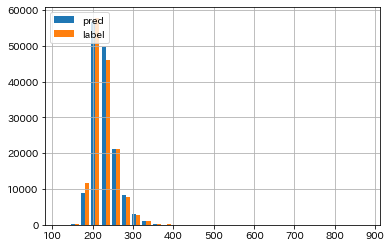

In [93]:
plt.hist([pred_train.reshape(-1), y_train.reshape(-1)], bins=30, label=['pred', 'label'])
plt.legend(loc='upper left')
plt.grid()
plt.show()

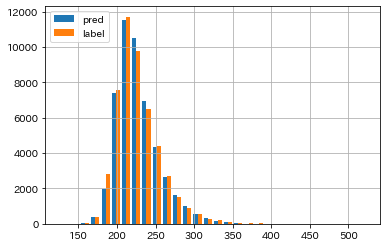

In [94]:
plt.hist([pred_test.reshape(-1), y_test.reshape(-1)], bins=30, label=['pred', 'label'])
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [ ]:
model_file = "../src/model.pkl"
with open(model_file, 'wb') as f:
        pickle.dump(model.to("cpu").state_dict(), f)
 
# load model
with open(model_file, mode='rb') as f:
       best_model = pickle.load(f)